In [2]:
#################################################################
#Developed by Jonathan Ojeda 05-03-2021 QAAFI-UQ
#Functionality:
#Convert from date to julian day
#Get soybean planting dates by US state using data from NASS-USDA
#Convert dtypes
#Locate specific rows and make a new dataframe
#create new rows with data
#Create campaig file for planting date
#Use of pivot table to trnspose data
#################################################################

In [1]:
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
import statsmodels.api as sm
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-9e9d1d5ccf14>:19: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


## Arrange sowing date dataframe from USDA to be inputted in psims

In [3]:
#read data
df=pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\USDA\sorghumgrain.csv')

#drop columns
df.drop(['freq_desc', 'county_name', 'util_practice_desc',
       'country_code', 'watershed_desc', 'domain_desc', 'class_desc',
       'county_code', 'region_desc', 'begin_code', 'load_time', 'county_ansi',
       'short_desc', 'source_desc', 'group_desc',
       'unit_desc', 'CV (%)', 'reference_period_desc', 'zip_5',
       'asd_desc', 'congr_district_code', 'location_desc',
       'prodn_practice_desc', 'domaincat_desc', 'commodity_desc',
       'country_name', 'watershed_code', 'sector_desc',
       'state_fips_code', 'agg_level_desc', 'statisticcat_desc', 'asd_code',
       'end_code'], axis=1, inplace=True)

#convert dtype
df['week_ending'] = df['week_ending'].astype('datetime64[ns]')

#convert from date to julian day 
#df['newFormat'] = df['week_ending'].dt.strftime('%y%j')
df['jday'] = df['week_ending'].dt.dayofyear.round(decimals=0)
#df['jday'] = df['newFormat'].str.slice(2,5)

#locate specific rows and make a new dataframe
df.loc[(df['Value'] > 25) & (df['Value'] < 75), 'pdate'] = df['jday']
df2 = df.loc[(df['jday'] > 60) & (df['jday'] < 181)]

#drop nan values
df3 = df2.dropna()
df3

,Value,state_name,week_ending,state_alpha,state_ansi,year,jday,pdate
2,44,COLORADO,1981-05-24,CO,8,1981,144,144.0
3,46,COLORADO,1981-05-31,CO,8,1981,151,151.0
14,55,KANSAS,1981-06-14,KS,20,1981,165,165.0
19,32,MISSOURI,1981-05-17,MO,29,1981,137,137.0
20,34,MISSOURI,1981-05-24,MO,29,1981,144,144.0
...,...,...,...,...,...,...,...,...
5352,45,TEXAS,2020-03-29,TX,48,2020,89,89.0
5353,52,TEXAS,2020-05-04,TX,48,2020,125,125.0
5355,64,TEXAS,2020-04-19,TX,48,2020,110,110.0
5356,67,TEXAS,2020-04-26,TX,48,2020,117,117.0


In [97]:
pdateb = df3.groupby(['state_alpha', 'state_ansi', 'state_name','year'],as_index=False).mean(['pdate','Value']).round(decimals=0)
pdateb.drop(['jday'], axis=1, inplace=True)
pdate1 = pdateb[pdateb['state_alpha'] != 'TN']
pdate2 = pdate1[pdate1['state_alpha'] != 'GA']
pdate0 = pdate2[pdate2['state_alpha'] != 'NC']
pdate = pdate0.where(pdate0['pdate'] > 75.00695999999999) #pdate.pdate.quantile(0.025618)
pdate

,state_alpha,state_ansi,state_name,year,Value,pdate
0,AR,5.0,ARKANSAS,1985.0,40.0,122.0
1,AR,5.0,ARKANSAS,1986.0,50.0,107.0
2,AR,5.0,ARKANSAS,1987.0,50.0,90.0
3,AR,5.0,ARKANSAS,1989.0,50.0,122.0
4,AR,5.0,ARKANSAS,1990.0,46.0,140.0
...,...,...,...,...,...,...
415,TX,48.0,TEXAS,2016.0,54.0,115.0
416,TX,48.0,TEXAS,2017.0,52.0,100.0
417,TX,48.0,TEXAS,2018.0,48.0,94.0
418,TX,48.0,TEXAS,2019.0,54.0,105.0


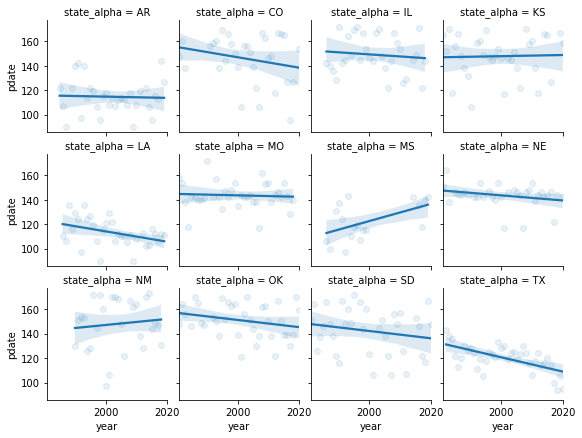

In [99]:
sns.lmplot(x="year", y="pdate",col='state_alpha', col_wrap=4, data=pdate, palette='Set1',scatter_kws={'alpha':0.1}, height=2)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\nasstime.png', dpi=300,bbox_inches='tight')

In [48]:
pdate = pdate[(pdate['year'] > 1999)]
sorghum0 = pdate.groupby(['state_alpha', 'state_ansi', 'state_name'],as_index=False).mean(['pdate','Value']).round(decimals=0)
sorghum0.drop(['year'], axis=1, inplace=True)
sorghum = sorghum0.sort_values(by=['pdate'])
sorghum

,state_alpha,state_ansi,state_name,Value,pdate
4,LA,22.0,LOUISIANA,49.0,110.0
0,AR,5.0,ARKANSAS,48.0,113.0
11,TX,48.0,TEXAS,56.0,116.0
10,SD,46.0,SOUTH DAKOTA,48.0,135.0
6,MS,28.0,MISSISSIPPI,51.0,136.0
1,CO,8.0,COLORADO,46.0,141.0
7,NE,31.0,NEBRASKA,50.0,141.0
5,MO,29.0,MISSOURI,49.0,142.0
2,IL,17.0,ILLINOIS,51.0,147.0
3,KS,20.0,KANSAS,48.0,147.0


In [89]:
corn = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\inputs\pdateCorn.csv')
final0 = pd.merge(corn, sorghum, how ='inner', on =['state_alpha'], suffixes=("_c", "_s"))
final = final0.drop(['Unnamed: 0','state_ansi','state_name_c'], axis=1)
final.rename(columns={'pdate+30':'pdate_c25', 'state_name_s':'state_name','STATE_FIPS':'state_fips'}, inplace=True)
final2A = final[(final['state_alpha'] != 'TX')]
final2 = final2A[(final2A['state_alpha'] != 'AR')]
final2

,state_alpha,state_fips,Value_c,pdate_c,pdate_c25,state_name,Value_s,pdate_s
0,LA,22.0,50.0,86.0,111.0,LOUISIANA,49.0,110.0
1,MS,28.0,52.0,105.0,130.0,MISSISSIPPI,51.0,136.0
4,OK,40.0,47.0,117.0,142.0,OKLAHOMA,48.0,147.0
5,MO,29.0,49.0,117.0,142.0,MISSOURI,49.0,142.0
6,KS,20.0,49.0,118.0,143.0,KANSAS,48.0,147.0
7,IL,17.0,50.0,120.0,145.0,ILLINOIS,51.0,147.0
8,NE,31.0,49.0,121.0,146.0,NEBRASKA,50.0,141.0


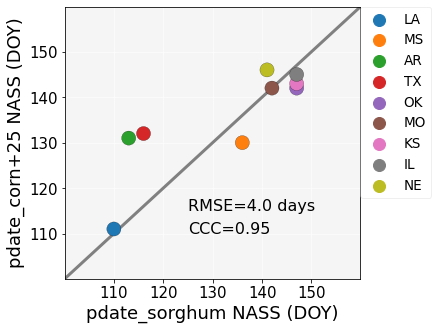

In [94]:
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(18,5))

ax=plt.subplot(1, 3, 1)
xmax=150
xmax20=xmax+(xmax*0.2)
ymax=150
ymax20=ymax+(ymax*0.2)

plt.plot([0,160],[0,160],"-",color="grey", linewidth=3,zorder=1)
sns.scatterplot(x="pdate_s", y="pdate_c25",hue='state_alpha', alpha=1, data=final, linewidth=0.2,**kwargs,s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13.5),bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('pdate_corn+25 NASS (DOY)', fontsize =18)
plt.xlabel('pdate_sorghum NASS (DOY)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([100.1,159.9])
ax.set_ylim([100.1,159.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(final2.pdate_s.values)
y_o= Obs.tolist()
Pre = pd.Series(final2.pdate_c25.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=0)
y_pre = array(y_p).round(decimals=0)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=0)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(125, 115,'RMSE='+RMSE+' days',fontsize=16,color='k')
plt.text(125, 110,'CCC='+CCC,fontsize=16,color='k')
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\nass.png', dpi=300,bbox_inches='tight')